# Compute metrics for different runs and plot them
##### author: Elizabeth A. Barnes, Randal J. Barnes and Mark DeMaria
##### version: v0.1.0
##### date: 14 December 2021

```
conda create --name env-hurr-tfp python=3.9
conda activate env-hurr-tfp
pip install tensorflow==2.7.0
pip install tensorflow-probability==0.15.0
pip install --upgrade numpy scipy pandas statsmodels matplotlib seaborn 
pip install --upgrade palettable progressbar2 tabulate icecream flake8
pip install --upgrade keras-tuner sklearn
pip install --upgrade jupyterlab black isort jupyterlab_code_formatter
pip install silence-tensorflow
pip install tqdm
```

Use the command
```python -m pip freeze > requirements.txt```
to make a pip installation list.

In [1]:
import datetime
import os
import pickle
import pprint
import time

import experiment_settings
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import shash
from build_data import build_hurricane_data
from build_model import build_shash_model, build_bnn_model
import model_diagnostics
from silence_tensorflow import silence_tensorflow
import prediction
from sklearn.neighbors import KernelDensity
import pandas as pd
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
tf.get_logger().setLevel('ERROR')

silence_tensorflow()
dpiFig = 400

In [2]:
__author__ = "Randal J Barnes and Elizabeth A. Barnes"
__version__ = "14 January 2022"

EXP_NAME_LIST = (
                 "intensity0_AL72",
                 "intensity1_AL72",
                 "intensity2_EPCP48",
                 "intensity3_EPCP48",
                 "intensity4_EPCP72",
                 "intensity5_EPCP72",
                 # "intensity7_EPCP72",    
                )

DATA_PATH = "data/"
MODEL_PATH = "saved_models/"
METRIC_PATH = "model_metrics/"

In [3]:
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["figure.dpi"] = 150
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

## Define get_metrics()

In [4]:
def get_metrics():
    tf.random.set_seed(network_seed)
    shash_incs = np.arange(-160,161,1)

    if settings["uncertainty_type"] == "bnn":       
        # loop through runs for bnn calculation    
        runs = 5_000
        bins_plot = np.linspace(np.min(shash_incs), np.max(shash_incs), 1000)
        bnn_cpd = np.zeros((np.shape(x_eval)[0],runs))
        bnn_mode = np.zeros((np.shape(x_eval)[0],))

        for i in tqdm(range(0,runs)):
            bnn_cpd[:,i] = np.reshape(model_bnn.predict(x_eval),np.shape(bnn_cpd)[0])
        bnn_mean = np.mean(bnn_cpd,axis=1)
        bnn_median = np.median(bnn_cpd,axis=1)

        for j in tqdm(range(0,np.shape(bnn_mode)[0])):
            kde = KernelDensity(kernel="gaussian", bandwidth=4.).fit(bnn_cpd[j,:].reshape(-1,1))
            log_dens = kde.score_samples(bins_plot.reshape(-1,1))
            i = np.argmax(log_dens)
            bnn_mode[j] = bins_plot[i]

        mean_error, median_error, mode_error = model_diagnostics.compute_errors(onehot_eval, bnn_mean, bnn_median, bnn_mode)         
        bins, hist_bnn, pit_D, EDp_bnn = model_diagnostics.compute_pit('bnn',onehot_eval, bnn_cpd)
        iqr_capture = model_diagnostics.compute_interquartile_capture('bnn',onehot_eval, bnn_cpd)
        
    else:        
        shash_cpd = np.zeros((np.shape(x_eval)[0],len(shash_incs)))
        shash_mean = np.zeros((np.shape(x_eval)[0],))
        shash_med = np.zeros((np.shape(x_eval)[0],))
        shash_mode = np.zeros((np.shape(x_eval)[0],))

        # loop through samples for shash calculation and get PDF for each sample
        for j in tqdm(range(0,np.shape(shash_cpd)[0])):
            mu_pred, sigma_pred, gamma_pred, tau_pred = prediction.params( x_eval[np.newaxis,j], model_shash )
            shash_cpd[j,:] = shash.prob(shash_incs, mu_pred, sigma_pred, gamma_pred, tau_pred)    
            shash_mean[j]  = shash.mean(mu_pred,sigma_pred,gamma_pred,tau_pred)#np.sum(shash_cpd[j,:]*shash_incs)
            shash_med[j]   = shash.median(mu_pred,sigma_pred,gamma_pred,tau_pred)

            i = np.argmax(shash_cpd[j,:])
            shash_mode[j]  = shash_incs[i]

        mean_error, median_error, mode_error = model_diagnostics.compute_errors(onehot_eval, shash_mean, shash_med, shash_mode)    
        bins, hist_shash, pit_D, EDp_shash = model_diagnostics.compute_pit('shash',onehot_eval, x_val=x_eval,model_shash=model_shash)
        iqr_capture = model_diagnostics.compute_interquartile_capture('shash',onehot_eval, x_val=x_eval,model_shash=model_shash)

    # by definition Consensus is a correction of zero
    cons_error = np.mean(np.abs(0.0 - onehot_eval[:,0]))
        
    return mean_error,median_error,mode_error,pit_D,iqr_capture,cons_error


## Evaluate the models

In [5]:
for exp_name in EXP_NAME_LIST:
    settings = experiment_settings.get_settings(exp_name)
    RNG_SEED_LIST = np.copy(settings['rng_seed'])

    for rng_seed in RNG_SEED_LIST:
        settings['rng_seed'] = rng_seed
        NETWORK_SEED_LIST = [settings["rng_seed"]]
        network_seed = NETWORK_SEED_LIST[0]
        tf.random.set_seed(network_seed)  # This sets the global random seed.    

        (
            x_train,
            onehot_train,
            x_val,
            onehot_val,
            x_eval,
            onehot_eval,    
            data_summary,
            df_val,
            df_eval,
        ) = build_hurricane_data(DATA_PATH, settings, verbose=0)

        if settings["uncertainty_type"] == "bnn":       
            model_name_bnn = (
                exp_name + "_" + settings["uncertainty_type"] + '_' + f"network_seed_{network_seed}_rng_seed_{settings['rng_seed']}"
            )
            pprint.pprint(model_name_bnn)

            model_bnn = build_bnn_model(
                x_train,
                onehot_train,
                hiddens=settings["hiddens"],
                output_shape=onehot_train.shape[1],
                ridge_penalty=settings["ridge_param"],
                act_fun=settings["act_fun"],
            )
            try:
                model_bnn.load_weights(MODEL_PATH + model_name_bnn + "_weights.h5")
            except:
                print('tf model does not exist. skipping...')
                continue
            model_name = model_name_bnn

        elif settings["uncertainty_type"][:5] == "shash": 
            model_name_shash = (
                exp_name + "_" + settings["uncertainty_type"] + '_' + f"network_seed_{network_seed}_rng_seed_{settings['rng_seed']}"
            )
            pprint.pprint(model_name_shash)

            model_shash = build_shash_model(
                x_train,
                onehot_train,
                hiddens=settings["hiddens"],
                output_shape=onehot_train.shape[1],
                ridge_penalty=settings["ridge_param"],
                act_fun=settings["act_fun"],
            )
            try:
                model_shash.load_weights(MODEL_PATH + model_name_shash + "_weights.h5")
            except:
                print('tf model does not exist. skipping...')
                continue
            model_name = model_name_shash

        # check if the metric filename exists already
        metric_filename = METRIC_PATH + model_name + '_metrics.pkl'
        if os.path.exists(metric_filename):
            print(metric_filename + ' exists. Skipping...')
            continue
            
        # get metrics and put into a dictionary
        mean_error, median_error, mode_error, pit_D, iqr_capture, cons_error = get_metrics()        
        d = {'uncertainty_type': settings["uncertainty_type"],
             'network_seed': network_seed,
             'rng_seed': settings['rng_seed'],
             'exp_name': exp_name,
             'mean_error': mean_error,
             'median_error': median_error,
             'mode_error': mode_error,
             'cons_error': cons_error,
             'pit_d': pit_D,
             'iqr_capture': iqr_capture,
        }
        pprint.pprint(d, width=80)  
        df = pd.DataFrame(data=d, index=[0])
        df.to_pickle(metric_filename)

settings["train_condition"] is undefined
'intensity0_AL72_shash3_network_seed_605_rng_seed_605'
model_metrics/intensity0_AL72_shash3_network_seed_605_rng_seed_605_metrics.pkl exists. Skipping...
settings["train_condition"] is undefined
'intensity0_AL72_shash3_network_seed_122_rng_seed_122'
model_metrics/intensity0_AL72_shash3_network_seed_122_rng_seed_122_metrics.pkl exists. Skipping...
settings["train_condition"] is undefined
'intensity0_AL72_shash3_network_seed_786_rng_seed_786'
model_metrics/intensity0_AL72_shash3_network_seed_786_rng_seed_786_metrics.pkl exists. Skipping...
settings["train_condition"] is undefined
'intensity0_AL72_shash3_network_seed_311_rng_seed_311'
model_metrics/intensity0_AL72_shash3_network_seed_311_rng_seed_311_metrics.pkl exists. Skipping...
settings["train_condition"] is undefined
'intensity0_AL72_shash3_network_seed_888_rng_seed_888'
model_metrics/intensity0_AL72_shash3_network_seed_888_rng_seed_888_metrics.pkl exists. Skipping...
settings["train_condition

/Users/eabarnes/miniforge3/envs/env-tfp-2.7/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  loc = add_variable_fn(
/Users/eabarnes/miniforge3/envs/env-tfp-2.7/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  untransformed_scale = add_variable_fn(


model_metrics/intensity1_AL72_bnn_network_seed_605_rng_seed_605_metrics.pkl exists. Skipping...
settings["train_condition"] is undefined
'intensity1_AL72_bnn_network_seed_122_rng_seed_122'
model_metrics/intensity1_AL72_bnn_network_seed_122_rng_seed_122_metrics.pkl exists. Skipping...
settings["train_condition"] is undefined
'intensity1_AL72_bnn_network_seed_786_rng_seed_786'
model_metrics/intensity1_AL72_bnn_network_seed_786_rng_seed_786_metrics.pkl exists. Skipping...
settings["train_condition"] is undefined
'intensity1_AL72_bnn_network_seed_311_rng_seed_311'
model_metrics/intensity1_AL72_bnn_network_seed_311_rng_seed_311_metrics.pkl exists. Skipping...
settings["train_condition"] is undefined
'intensity1_AL72_bnn_network_seed_888_rng_seed_888'
model_metrics/intensity1_AL72_bnn_network_seed_888_rng_seed_888_metrics.pkl exists. Skipping...
settings["train_condition"] is undefined
'intensity1_AL72_bnn_network_seed_999_rng_seed_999'
model_metrics/intensity1_AL72_bnn_network_seed_999_rng_

In [6]:
df_metrics = pd.DataFrame()

for exp_name in EXP_NAME_LIST:
    settings = experiment_settings.get_settings(exp_name)
    RNG_SEED_LIST = np.copy(settings['rng_seed'])
    
    for rng_seed in RNG_SEED_LIST:
        settings['rng_seed'] = rng_seed
        NETWORK_SEED_LIST = [settings["rng_seed"]]
        network_seed = NETWORK_SEED_LIST[0]
    
        model_name = (
                exp_name + "_" + settings["uncertainty_type"] + '_' + f"network_seed_{network_seed}_rng_seed_{settings['rng_seed']}"
        )
    
        
        # load the metric filename
        metric_filename = METRIC_PATH + model_name + '_metrics.pkl'
        if os.path.exists(metric_filename)==False:
            print(metric_filename + ' DOES NOT exist. Skipping...')
            continue
        
        df = pd.read_pickle(metric_filename)
        df['basin_lead'] = exp_name[exp_name.rfind('_')+1:]
        df['mean_improvement'] = df['cons_error']-df['mean_error']
        df['median_improvement'] = df['cons_error']-df['median_error']        
        df['mode_improvement'] = df['cons_error']-df['mode_error']        
        df_metrics = pd.concat([df_metrics,df])
df_metrics

,uncertainty_type,network_seed,rng_seed,exp_name,mean_error,median_error,mode_error,cons_error,pit_d,iqr_capture,basin_lead,mean_improvement,median_improvement,mode_improvement
0,shash3,605,605,intensity0_AL72,11.104087,11.228001,12.044000,12.312667,0.009189,0.516667,AL72,1.208580,1.084665,0.268667
0,shash3,122,122,intensity0_AL72,11.645948,11.715523,13.290333,11.986333,0.014298,0.490000,AL72,0.340385,0.270811,-1.304000
0,shash3,786,786,intensity0_AL72,11.631342,11.480208,12.108667,11.999333,0.015055,0.513333,AL72,0.367991,0.519125,-0.109333
0,shash3,311,311,intensity0_AL72,11.128194,10.872625,11.609000,11.382333,0.023944,0.546667,AL72,0.254139,0.509709,-0.226667
0,shash3,888,888,intensity0_AL72,11.172096,11.377948,12.715667,12.403000,0.024944,0.430000,AL72,1.230904,1.025052,-0.312667
0,shash3,999,999,intensity0_AL72,11.452033,11.148157,11.430333,11.493000,0.017701,0.540000,AL72,0.040967,0.344843,0.062667
0,shash3,578,578,intensity0_AL72,11.791927,11.765272,12.654333,12.792334,0.027568,0.473333,AL72,1.000407,1.027061,0.138000
0,shash3,331,331,intensity0_AL72,10.539050,10.422472,11.562000,11.191999,0.016465,0.523333,AL72,0.652949,0.769527,-0.370001
0,shash3,908,908,intensity0_AL72,10.511910,10.473817,11.286333,11.921667,0.012824,0.510000,AL72,1.409757,1.447850,0.635334
0,shash3,444,444,intensity0_AL72,12.496201,12.331341,13.125000,12.562334,0.024540,0.536667,AL72,0.066133,0.230994,-0.562666


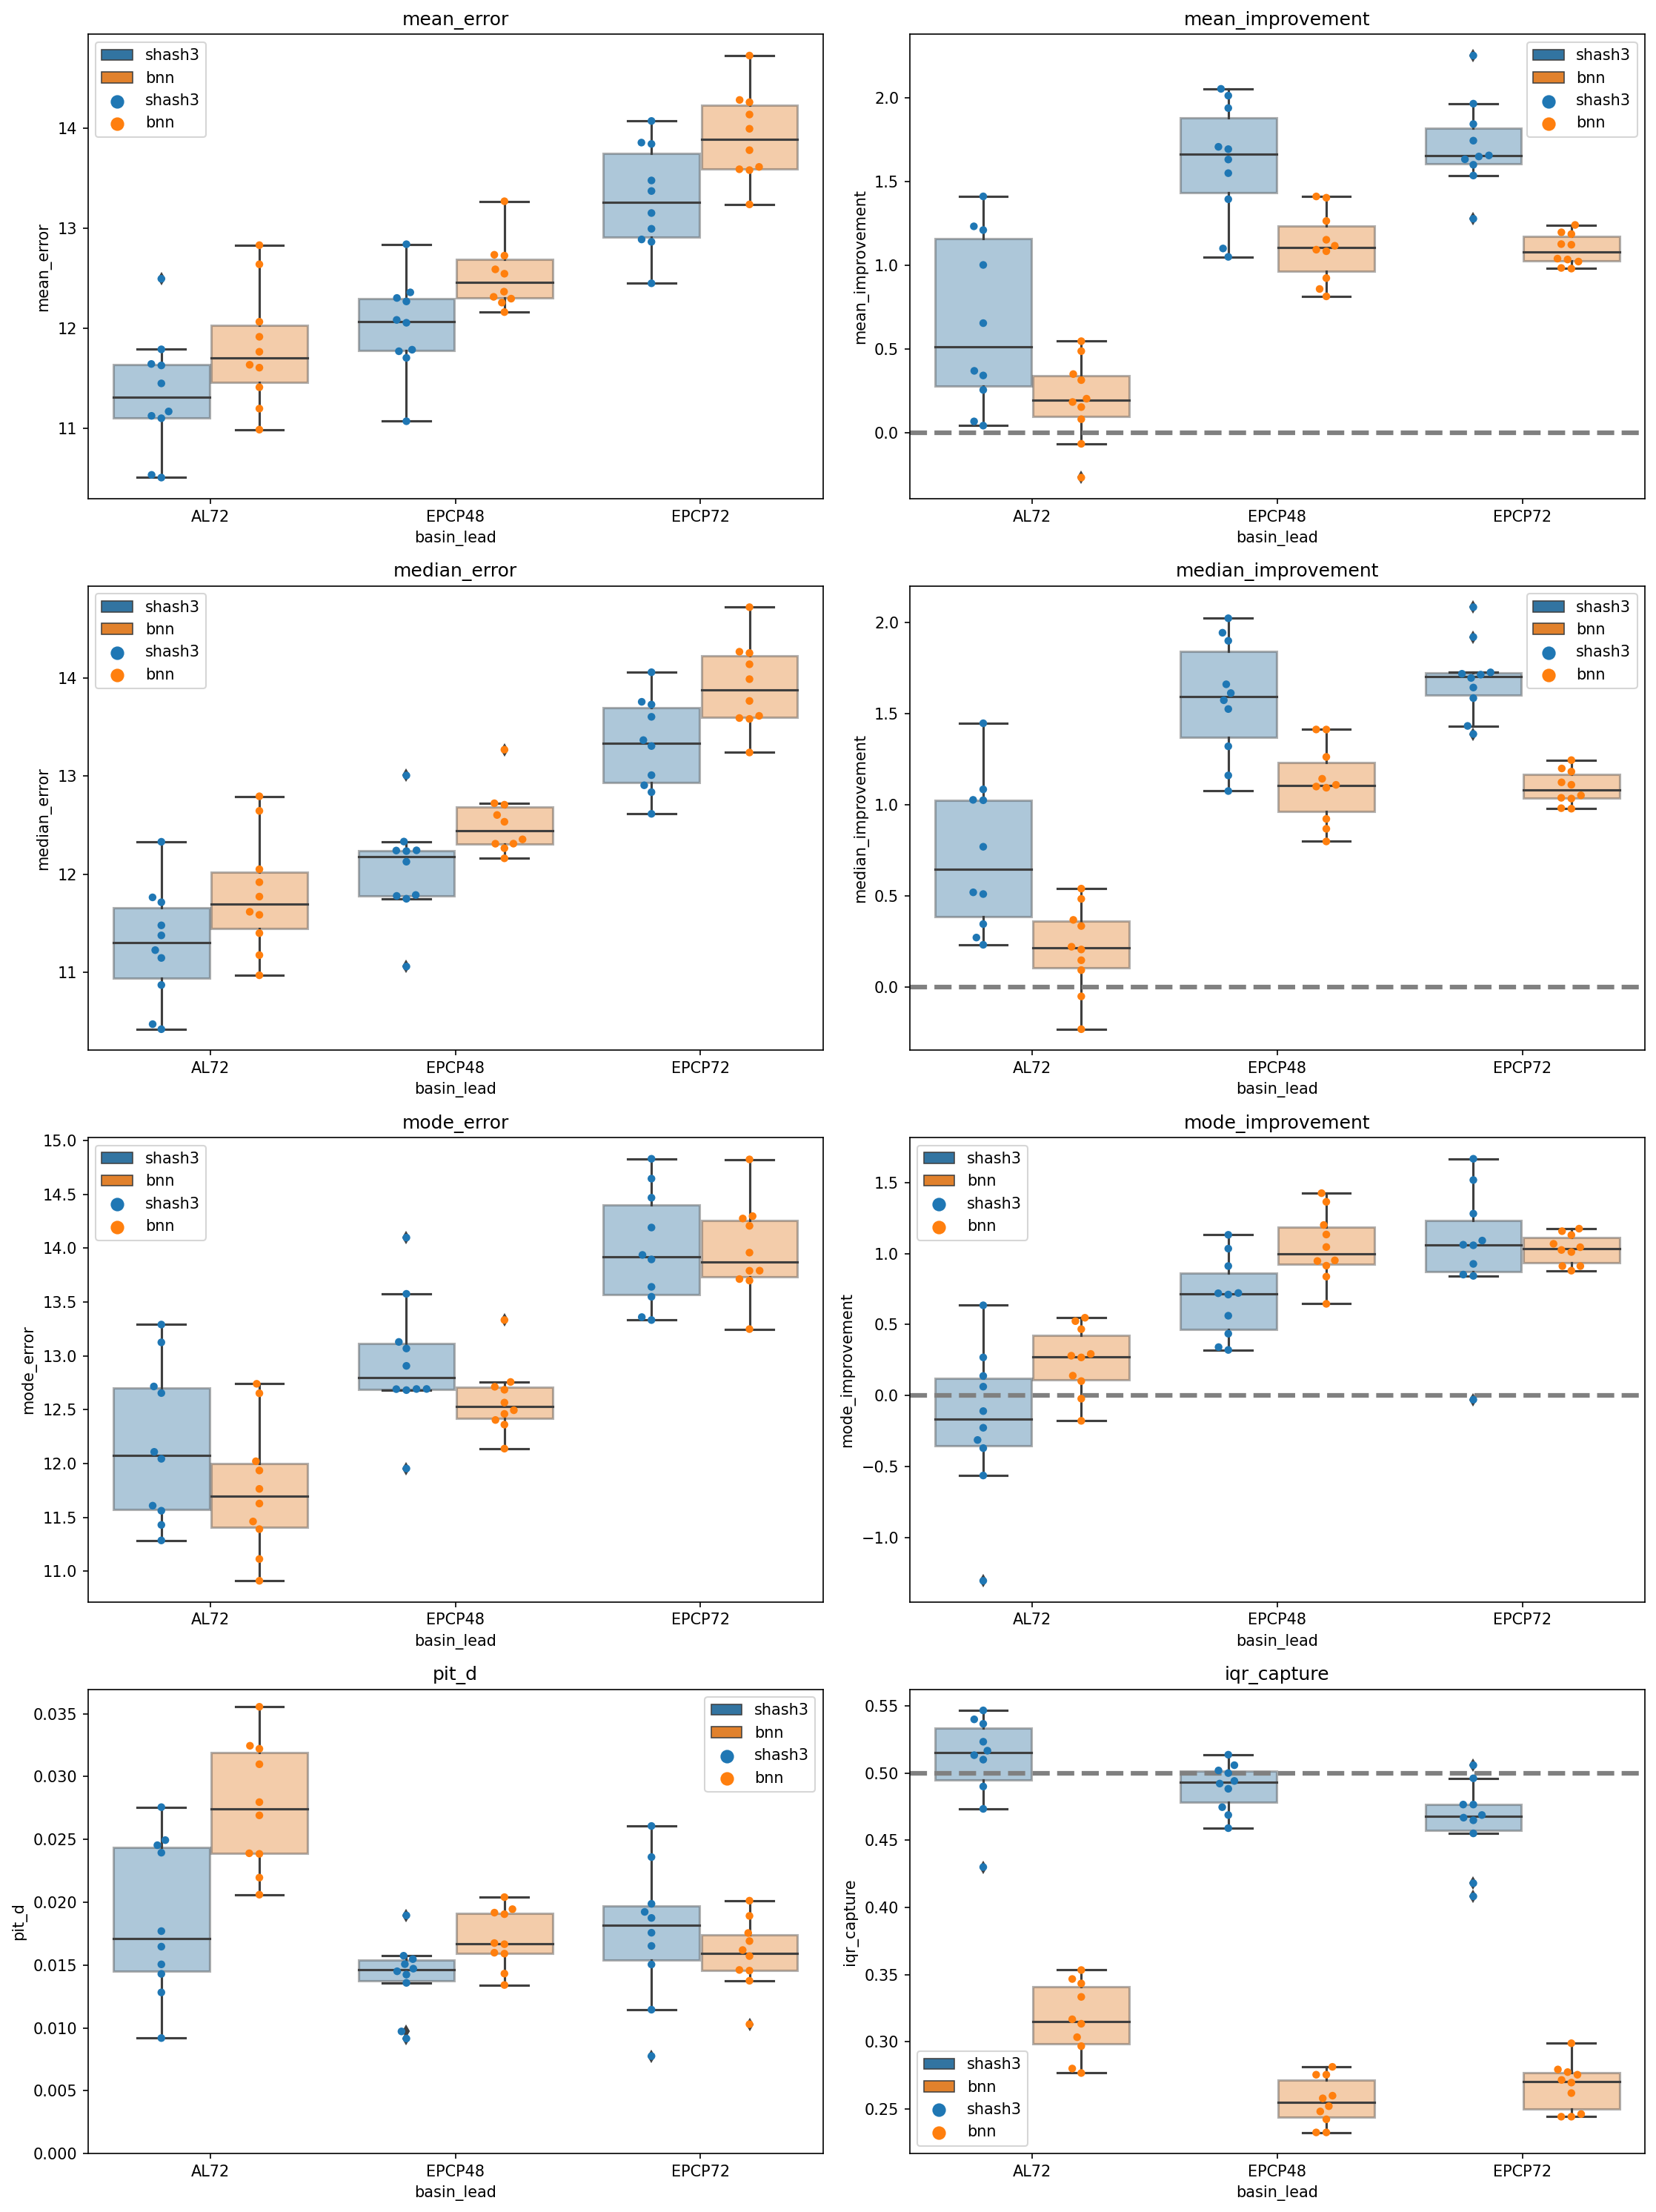

In [7]:
import seaborn as sns
f, axs = plt.subplots(4, 2, figsize=(15,20))
axs = axs.flatten()

for imetric, metric in enumerate(('mean_error',
                                  'mean_improvement',
                                  'median_error',
                                  'median_improvement',                                  
                                  'mode_error',
                                  'mode_improvement',                                  
                                  'pit_d',
                                  'iqr_capture')):
    ax = axs[imetric]
    g1 = sns.boxplot(x='basin_lead', 
                     y=metric, 
                     hue="uncertainty_type",
                     data=df_metrics,
                     boxprops=dict(alpha=.4),
                     ax=ax)
    g2 = sns.swarmplot(x="basin_lead", 
                       y=metric, 
                       hue="uncertainty_type", 
                       data=df_metrics, 
                       dodge=True,
                       ax=ax)
    
    if(metric=='iqr_capture'):
        ax.axhline(y=0.5,linewidth=3,linestyle='--',color='gray')
    if(metric=='pit_d'):
        ax.set_ylim(0,None)
    if(metric.find('improvement') > -1):
        ax.axhline(y=0.0,linewidth=3,linestyle='--',color='gray')
    
    ax.set_title(metric)
    ax.legend(fontsize=10,frameon=True)

plt.savefig('figures/prediction_plots/comparisonsMetrics.png', dpi=dpiFig)    
plt.tight_layout()
plt.show()